In [1]:
import numpy as np
from numpy import matmul, transpose, matrix, multiply, divide,sqrt,diag,log,pi
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd
from numpy.linalg import eigvals, eig
from scipy.special import gammaln
import sys
%matplotlib inline  


In [2]:
def ltpdf(x,m,w,n,D):
    q = x.shape[0]
    C = transpose(np.linalg.cholesky(D));
    e = inv(C)@(x-m);
    d = n+q-1;
    ltpdf = q*np.log(2)/2 - q*np.log(2*pi*w)/2 -sum(np.log(diag(C))) -(d+1)*np.log(1+(transpose(e)@e)/w)/2;
    ltpdf += sum(gammaln(1 + d - np.array(list(range(0,q))))/2) - sum(gammaln(d - np.array(list(range(0,q))))/2)
    return(ltpdf)

In [3]:
# M.W example data
#data = pd.read_excel('/Users/mueric35/Desktop/Share/FXCommData2000-2011.xlsx')
#del data['USD-SGD']
#Y = matrix(data)
#Y = transpose(Y[1:,]/Y[:-1,:]-1)*100
#q,T = Y.shape

In [4]:
# data of daily difference

#df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily.csv', index_col= 0)
#Y = 100 * matrix(df.iloc[:,[i-1 for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]])
#T,q = Y.shape
#Y = transpose(Y)

## standardize
#Y = Y - np.mean(Y,axis = 1)
#Y = Y/np.std(Y,axis = 1)


In [5]:
# data for log transformation
df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all_daily_raw.csv', index_col= 0)
Y = matrix(df.iloc[:,[i-1 for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]])
T,q = Y.shape
Y = transpose(Y)
Y[Y == 0] = 1
Y = log(Y)

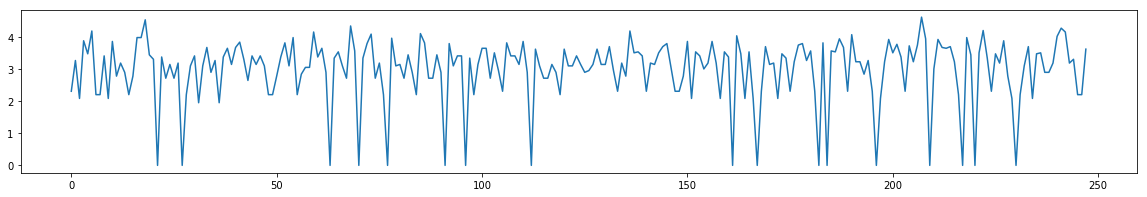

In [6]:
plt.figure(figsize=(20,3))
plt.plot(transpose(Y)[:,0]);

In [7]:
# select variable from Hierachical Clustering ... Done in R
name = [df.columns[i-1] for i in [7 , 72 , 78 , 81 , 93 ,103 ,107 ,125 ,127 ,130 ,141 ,143 ,151 ,152]]
name

['community bank',
 'the great depression',
 'gold stock price',
 'associated press',
 'berkeley county',
 '1929',
 'berkeley electric',
 'massachusetts',
 'gold stock',
 'cost stock',
 'procter gamble stock',
 'political quiz',
 'gold price',
 'bitcoin price']

In [8]:
## only for local level , thus p = 1
class multi_filtering(object):
    
    def __init__(self, Y = Y ,m0 = matrix(np.ones([1,q])),
                 c0 = 0.01 , n0 = 3 ,beta = 0.9, delta = 0.9, backwardSmooth = False, Print = True):
        
        #change discounts to assess, compare marginal likelihood
        p=1;   
        F=np.matrix(np.ones([1,T]));

        #delta = 0.9; # discount level
        #beta = 0.9;  # discount volatility

        n0 = n0 ; 
        h0=n0+q-1; 
        D0=np.matrix(h0*np.identity(q));

        z = np.ones([p,q]);  
        zq=np.zeros([q,1]); 

        M0 = m0; 
        r=0.99; # priors
        Mt = M0;

        C0= np.matrix( c0 *np.identity(p))
        Ct=C0;        # initial Theta prior 

        n = n0; 
        h=h0;
        D = D0; 
        St=D/h;         # initial Sigma prior


        sMt = np.ones([p,q,T]); 
        sCt=np.zeros([p,p,T]);
        sdCt=np.zeros([p,q,T]);
        sSt=np.zeros([q,q,T]);  
        snt=np.zeros(T);
        sloglik=np.zeros(T); 

        sEt = matrix(np.zeros([q,T]))

        eigs = np.zeros([q,T])
        
        self.M0 = M0
        self.C0 = C0
        self.S0 = St
        self.delta = delta
        self.beta = beta
        
        if Print:
            print('Start forward filtering...')
        
        # # forward filtering: 
        for t in range(T):

            ft = np.matrix(transpose(Mt) @ F[:,t])
            et = Y[:,t] - ft;
            Rt = Ct/delta; 
            h  = beta*h; 
            n=h-q+1; 
            D = beta*D;  
            snt[t]=n;  
            qvt = 1 + transpose(F[:,t])@Rt@F[:,t]; 
            sEt[:,t] = transpose(np.squeeze(et)/np.sqrt(qvt*np.diag(St)))

            At = Rt@F[:,t]/qvt;
            h += 1; 
            n += 1; 
            D += et @ transpose(et)/qvt
            St=D/h; 
            St=(St+transpose(St))/2; 
            Mt = Mt + At@transpose(et);
            Ct = Rt - At@np.transpose(At)*qvt;

            #
            sloglik[t] = ltpdf(et,zq,qvt,n,D);    

            # PCA

            eig_vals, eig_vecs = eig(St)
            eig_vals_sorted = np.sort(eig_vals)[::-1]
            eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()[::-1]]
            eigs[:,t] =eig_vals_sorted

            # save
            sCt[:,:,t]=Ct;
            sSt[:,:,t]=St; 
            sMt[:,:,t] = Mt; 
            sdCt[:,:,t] = sqrt(transpose(diag(Ct)*diag(St)));
        
        
        if Print:
            print('Start Backward Smoothing...')
                
        if backwardSmooth:
            # reverse smoothing 
            K=inv(sSt[:,:,-1]); 
            n=snt[:-1]; 
            Mt = sMt[:,:,-1]; 
            Ct = sCt[:,:,-1]; 

            for t in list(range(1,T-1))[::-1]:
                K=(1-beta)*inv(sSt[:,:,t])+beta*K;         
                St = inv(K); 
                sSt[:,:,t]=St;  
                Mt = (1-delta)*sMt[:,:,t] +delta*Mt;  
                sMt[:,:,t] = Mt; 
                Ct = (1-delta)*sCt[:,:,t] + np.power(delta,2)*Ct;    
                sCt[:,:,t] = Ct; 
                sdCt[:,:,t] = sqrt(diag(Ct)* transpose(diag(St)));
            
        self.sCt = sCt
        self.sSt = sSt
        self.sMt = sMt
        self.sdCt = sdCt
        self.eigs = eigs
        self.sloglik = sloglik
        
        if Print:
            print('Finished...')

In [9]:
# Tuned Beta and Delta
Beta = np.round(np.linspace(start=0.9,stop= 1,num=10),2)
Delta = np.round(np.linspace(start=0.9,stop= 1,num=10),2)


In [10]:
# Tuned Beta and Delta
loglik = {}
for beta in Beta:
    for delta in Delta:
        filt = multi_filtering(beta = beta, delta=delta, Print = False)
        loglik.update({str(beta) + '-' +str(delta):filt.sloglik})

/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: ComplexWarning: Casting complex values to real discards the imaginary part


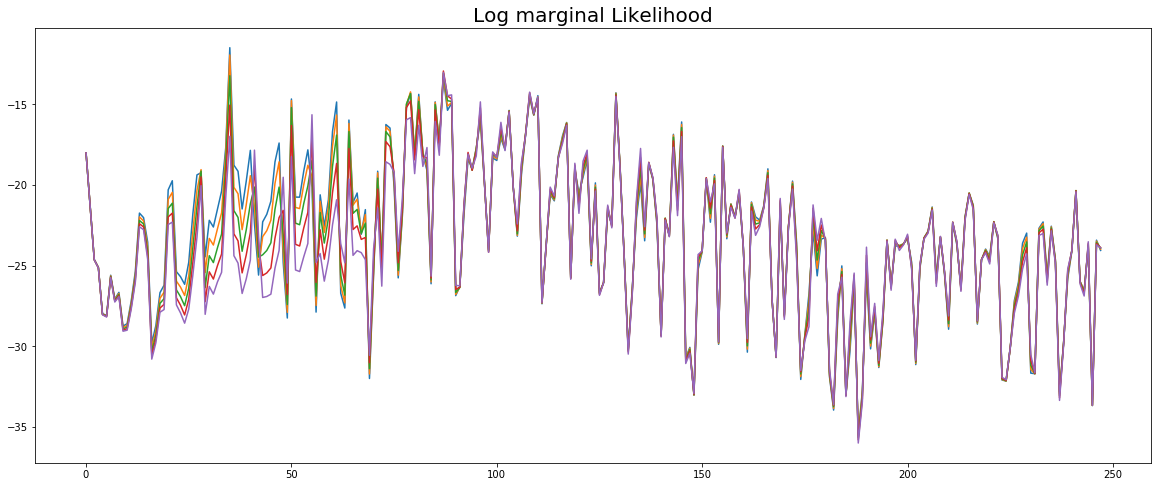

In [11]:
# log marginal Likelihood
plt.figure(figsize=(20,8))
for i in list(loglik.keys())[:5]:
    plt.plot(loglik.get(i))
    plt.title('Log marginal Likelihood', fontsize = 20);
    # add legend

In [12]:
## Report optimal Delta and Beta

In [13]:
for key, item in loglik.items():
    print(key, np.cumsum(item)[-1])

0.9-0.9 -5731.95229723
0.9-0.91 -5756.75039022
0.9-0.92 -5788.8785351
0.9-0.93 -5830.18002049
0.9-0.94 -5883.79077105
0.9-0.96 -6057.77342727
0.9-0.97 -6211.87003748
0.9-0.98 -6465.94837703
0.9-0.99 -6883.14825118
0.9-1.0 -7457.1696992
0.91-0.9 -4594.30595934
0.91-0.91 -4620.35132183
0.91-0.92 -4654.11521532
0.91-0.93 -4697.51762378
0.91-0.94 -4753.83576477
0.91-0.96 -4936.58443438
0.91-0.97 -5099.49576157
0.91-0.98 -5365.75297527
0.91-0.99 -5801.6702912
0.91-1.0 -6420.62310894
0.92-0.9 -4379.26936509
0.92-0.91 -4406.6537965
0.92-0.92 -4442.17285458
0.92-0.93 -4487.87238841
0.92-0.94 -4547.20610167
0.92-0.96 -4739.81361945
0.92-0.97 -4912.21573473
0.92-0.98 -5190.82245874
0.92-0.99 -5647.93496324
0.92-1.0 -6318.03239688
0.93-0.9 -3912.52243179
0.93-0.91 -3941.2366762
0.93-0.92 -3978.50767543
0.93-0.93 -4026.56200988
0.93-0.94 -4089.07671291
0.93-0.96 -4292.48345851
0.93-0.97 -4474.71176065
0.93-0.98 -4765.86395736
0.93-0.99 -5247.40741233
0.93-1.0 -5974.99721938
0.94-0.9 -3608.79019641

In [14]:
# Model with beta* and delta*
model = multi_filtering(beta = 0.98, delta = 0.9, backwardSmooth = False)
sSt = model.sSt
sdCt = model.sdCt
sMt = model.sMt
sloglik = model.sloglik
eigs = model.eigs

Start forward filtering...
Start Backward Smoothing...
Finished...


/Users/mueric35/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: ComplexWarning: Casting complex values to real discards the imaginary part


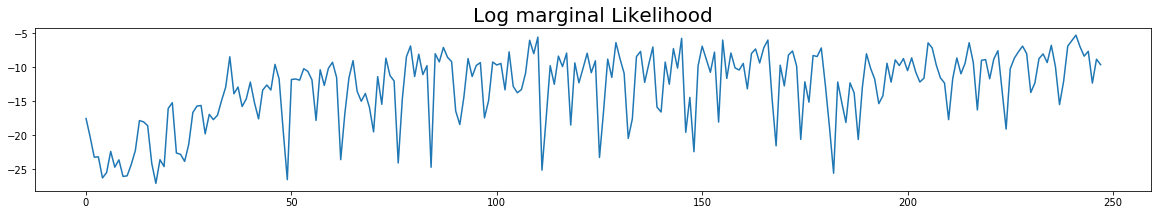

In [15]:
plt.figure(figsize=(20,3))
plt.plot(sloglik);
plt.title('Log marginal Likelihood', fontsize = 20);

## Eigenvalue

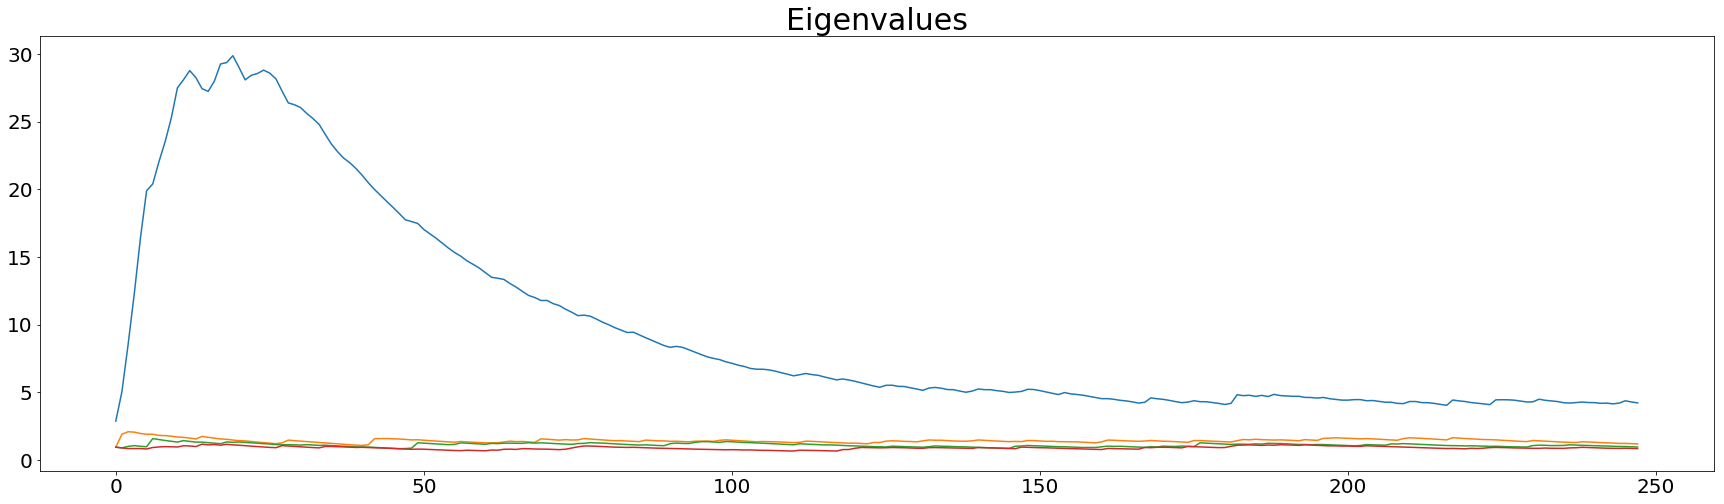

In [16]:
plt.figure(figsize=(30,8))
for i in range(4):
    plt.plot(np.array(eigs[i,:]));
    plt.tick_params(labelsize=20)
    plt.title('Eigenvalues', fontsize = 30)



## Cumulative Variance Explained by components

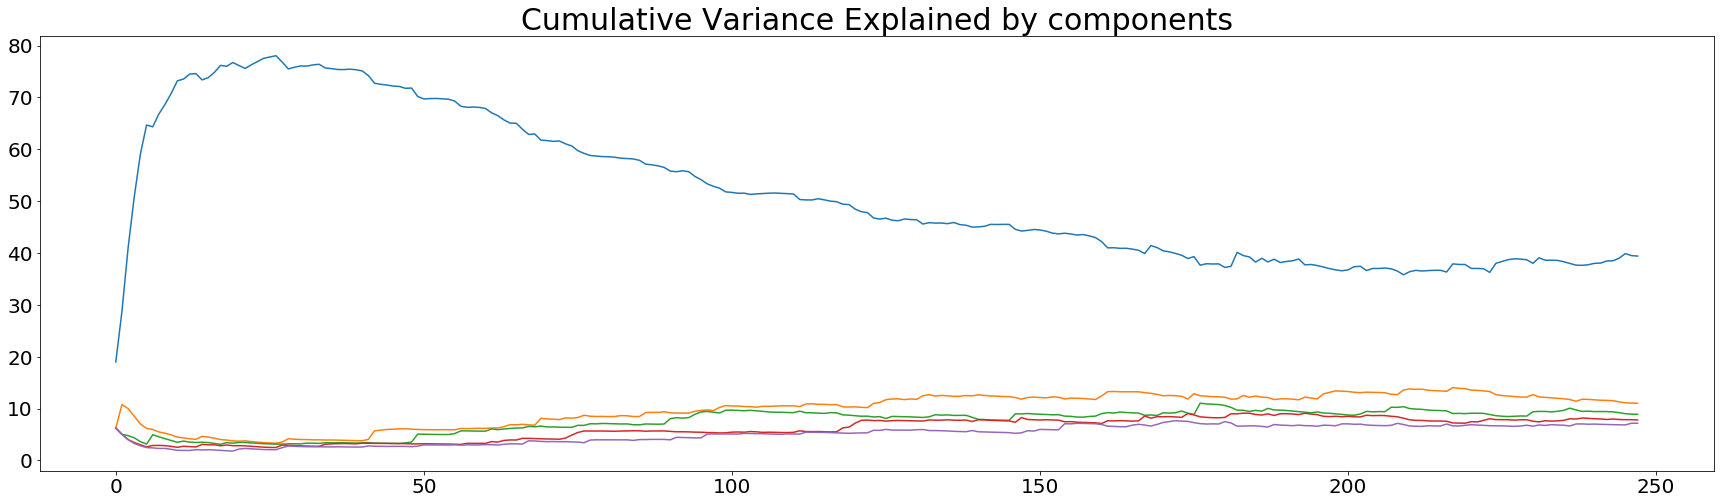

In [17]:
eigs_frac = 100*eigs/np.sum(eigs,axis = 0)
plt.figure(figsize=(30,8))
for i in range(5):
    plt.plot(eigs_frac[i,:])
    plt.tick_params(labelsize=20)
    plt.title('Cumulative Variance Explained by components', fontsize = 30)



## Plot Data

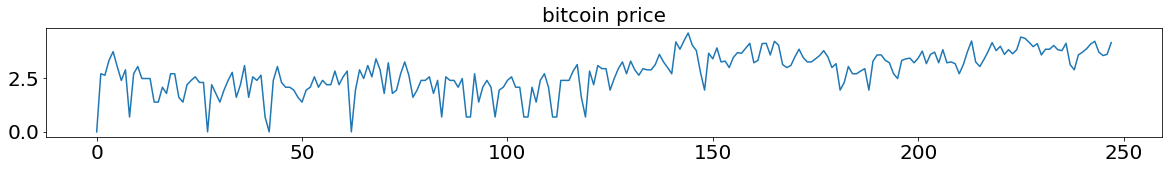

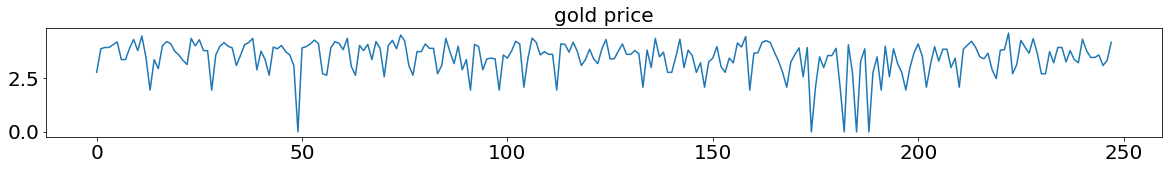

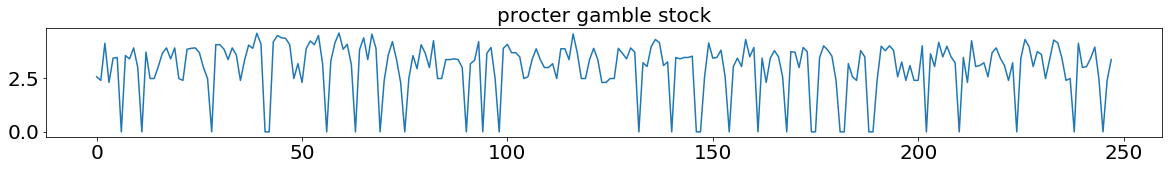

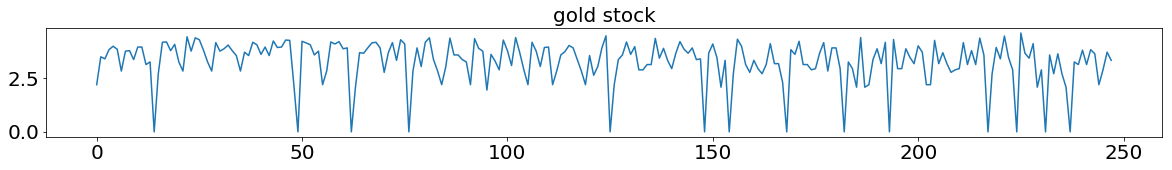

In [18]:
index = 13

def plot_data(index):
    plt.figure(figsize=(20,2))
    topic = name[index]
    plt.plot(transpose(Y[index,:]));
    plt.title(str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)

plot_data(index)
plot_data(12)
plot_data(10)
plot_data(8)

## Plot Volatility 

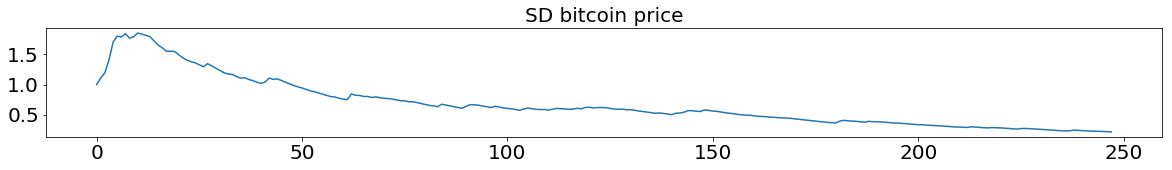

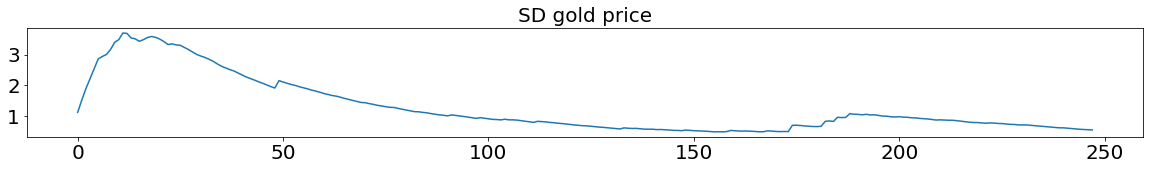

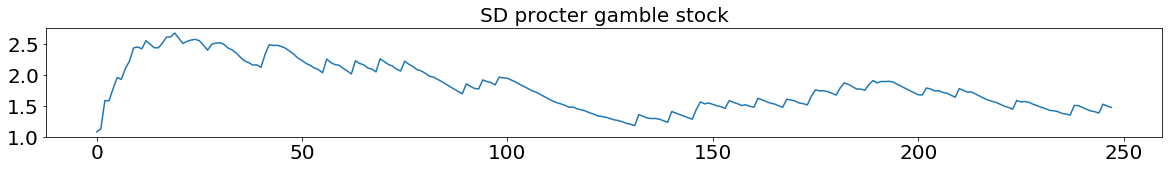

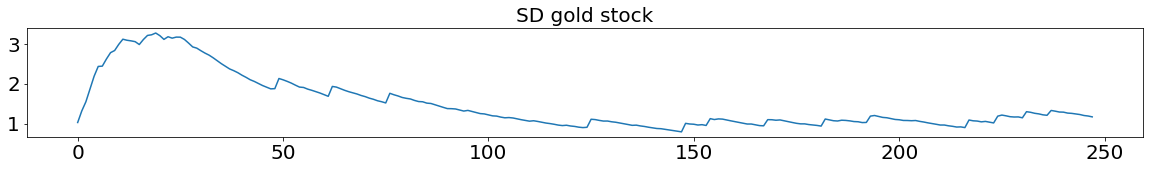

In [19]:
def plot_vol(index):
    topic = name[index]
    plt.figure(figsize=(20,2))
    plt.plot(sSt[index,index,:]);
    plt.title( 'SD '+ str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)

plot_vol(index)
plot_vol(12)
plot_vol(10)
plot_vol(8)



## Plot Correlation

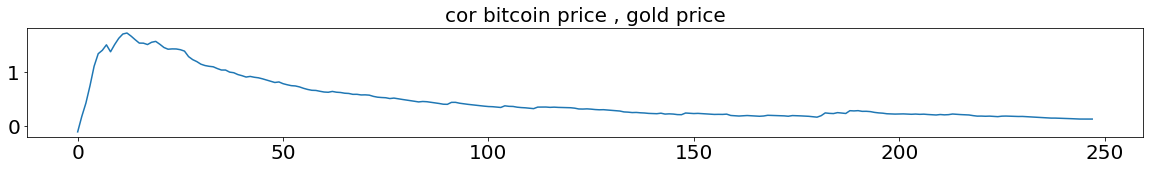

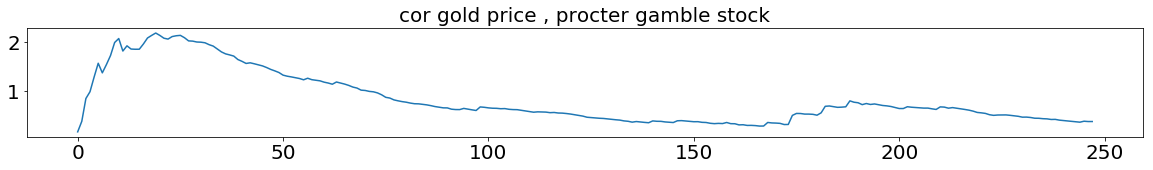

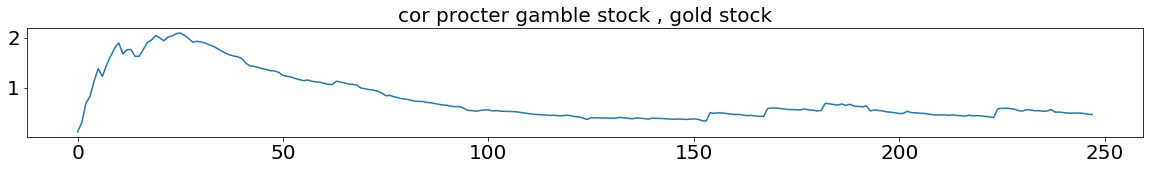

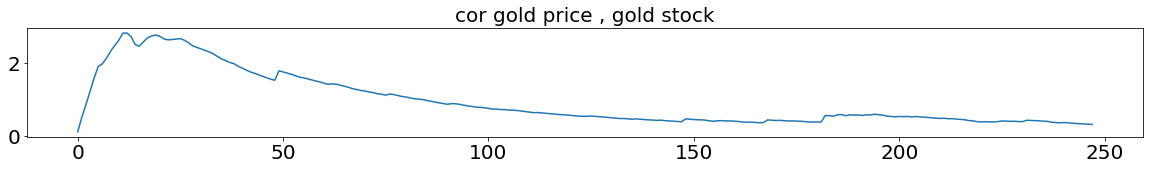

In [21]:
def plot_cor(index):
    topic = [name[i] for i in index]
    plt.figure(figsize=(20,2))
    plt.plot(sSt[index[0],index[1],:]);
    title = ' , '.join(t for t in topic)
    plt.title('cor ' + title, fontsize = 20)
    plt.tick_params(labelsize=20)
plot_cor([13,12])
plot_cor([12,10])
plot_cor([10,8])
plot_cor([12,8])


## Plot State

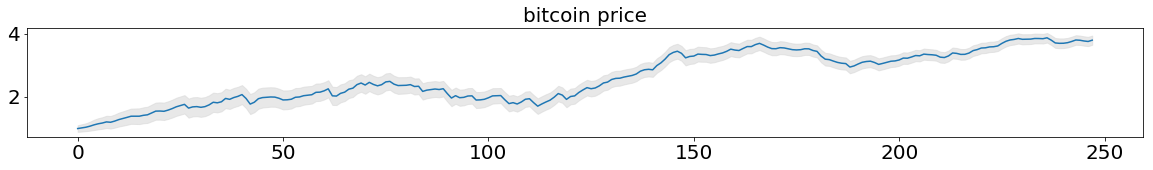

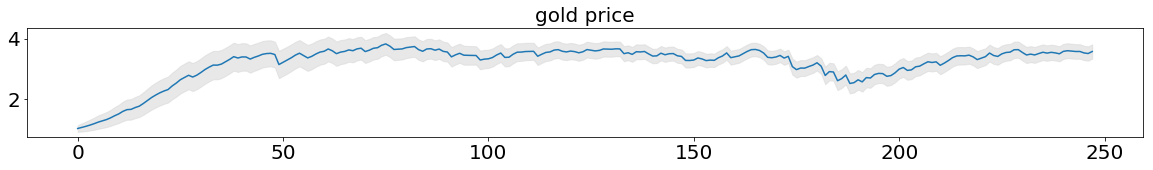

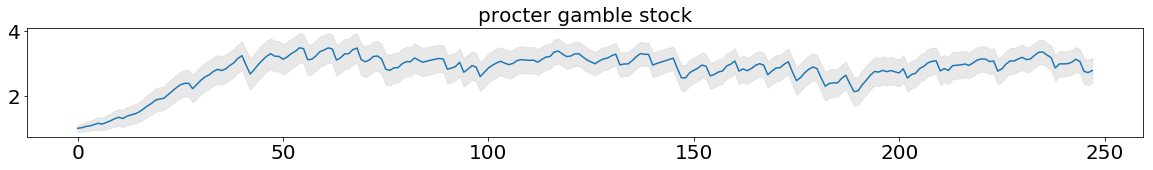

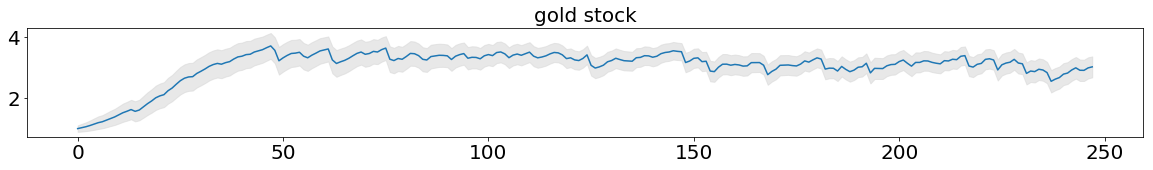

In [22]:
def plot_mt(index):
    plt.figure(figsize=(20,2))
    sct= np.squeeze(sdCt[0,index,:]);
    higher = np.squeeze(sct + sMt[0,index,:])
    lower = np.squeeze(sMt[0,index,:] - sct)

    plt.fill_between(range(len(np.array(higher))),
                     np.array(higher).flatten().tolist(), 
                     np.array(lower).flatten().tolist(), color='lightgray', alpha=0.5)
    topic = name[index]
    plt.plot(sMt[0,index,:]);
    plt.title(str(topic), fontsize = 20)
    plt.tick_params(labelsize=20)
plot_mt(index)
plot_mt(12)
plot_mt(10)
plot_mt(8)